<a href="https://colab.research.google.com/github/michalprusek/SU1-z-po-et/blob/main/100_Final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Cíl
Cílem tohoto projektu je klasifikovat mou rukou psané číslice.

Ke klasifikaci využívám fúzi tří modelů - kNN, SVM, Random Forest.

Příznaky jsou vytvořeny pomocí Fourierových deskriptorů kontur jednotlivých číslic. Je ponecháno prvních 30. Jednotlivé Fourierovy deskriptory jsou ve formě komplexních čísel. Tudíž vzniká celkem 60-dimenzionální příznakový prostor.

Výsledkem je pak program, který na základě poskytnuté sekvence rukou napsaných číslic dokáže tyto číslice rozpoznat a převést na pole znaků.

## Dataset

Dataset obsahuje celkem 10 tříd (číslice od 0 do 9). Pro každou třídu se v datasetu nachází přibližně 800 vzorků (obrázků číslice). Ukázky číslic z datasetu vypadají následovně:

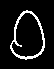
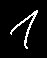
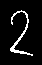
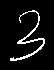
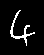
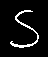
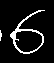
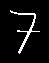
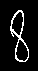
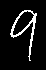

dataset k dispozici na: [github - dataset](https://github.com/michalprusek/SU1-z-po-et/tree/main)

Zároveň součástí datasetu jsou i napočítané Fourierovy deskriptory, celého datasetu uložené do npy souboru.




## Code

### Imports

In [81]:
import numpy as np
from collections import Counter
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import sys
import cv2 as cv
import matplotlib.pyplot as plt

###kNN Class

In [82]:
class kNN:
    def __init__(self, kNeighbours, X_train, y_train):
        self.k = kNeighbours
        self.X_train = X_train
        self.y_train = y_train


    def predict(self, X_test):
      y_predicted = []
      distances = np.zeros((self.X_train.shape[0]))
      for seq in X_test:
        for i in range(distances.shape[0]):
          mensi = min(len(seq), len(self.X_train[i]))
          norma = np.linalg.norm(seq[:mensi] - self.X_train[i][:mensi])

          distances[i] = norma


        kNNGestures = []
        for i in range(self.k):
          argMin = np.argmin(distances)
          kNNGestures.append(self.y_train[argMin])
          distances[argMin] = np.max(distances)

        b = Counter(kNNGestures)

        vyherniGesto = b.most_common(1)[0][0]

        y_predicted.append(vyherniGesto)

      return y_predicted

    def metrics(self, y_predicted, y_test):
        print(confusion_matrix(y_predicted, y_test))
        print(classification_report(y_predicted, y_test))

### SVM Class

In [83]:
class SVM:
    def __init__(self, X_train, y_train):
        self.X_train = self.separate_real_imaginary_list(X_train)
        self.y_train = y_train

    def fit(self):
        self.svm_classifier = SVC(kernel='rbf', gamma='scale', decision_function_shape='ovr')
        self.svm_classifier.fit(self.X_train, self.y_train)

    def predict(self,  X_test):
        X_test = self.separate_real_imaginary_list(X_test)
        y_predicted = self.svm_classifier.predict(X_test)
        return y_predicted

    def metrics(self, y_predicted, y_test):
        print(confusion_matrix(y_predicted, y_test))
        print(classification_report(y_predicted, y_test))

    def separate_real_imaginary_list(self, descriptors):
        feature_vectors = []
        for seq in descriptors:
            real_parts = np.real(seq)
            imaginary_parts = np.imag(seq)
            feature_vectors.append(np.concatenate((real_parts, imaginary_parts)))

        return feature_vectors

### Random Forest Class

In [84]:
class RandomForest:
    def __init__(self, X_train, y_train):
        self.X_train = self.separate_real_imaginary_list(X_train)
        self.y_train = y_train

    def fit(self):
        self.rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
        self.rf_classifier.fit(self.X_train, self.y_train)

    def predict(self, X_test):
        X_test = self.separate_real_imaginary_list(X_test)
        y_predicted = self.rf_classifier.predict(X_test)
        return y_predicted

    def metrics(self, y_predicted, y_test):
        print(confusion_matrix(y_predicted, y_test))
        print(classification_report(y_predicted, y_test))

    def separate_real_imaginary_list(self, descriptors):
        feature_vectors = []
        for sequence in descriptors:
            real_parts = np.real(sequence)
            imaginary_parts = np.imag(sequence)
            feature_vectors.append(np.concatenate((real_parts, imaginary_parts)))

        return feature_vectors

### Other Functions

In [85]:
def winners(knn_predicted, svm_predicted, rf_predicted):
  if len(knn_predicted) == len(svm_predicted) == len(rf_predicted):
    winners_array = []
    for i in range(len(rf_predicted)):
        arr = [knn_predicted[i], svm_predicted[i], rf_predicted[i]]
        b = Counter(arr)

        winner = b.most_common(1)[0][0]
        winners_array.append(winner)

    return winners_array
  else:
    print("pole nemají stejnou délku")
    sys.exit()

def metrics(y_predicted, y_test):
    print(confusion_matrix(y_predicted, y_test))
    print(classification_report(y_predicted, y_test))

def fourier_descriptors(contour, num):
    contour_complex = contour[:, 0, 0] + contour[:, 0, 1] * 1j
    ft_contour = np.fft.fft(contour_complex)
    fd = ft_contour[1:num + 1] / (len(ft_contour) ** 2)
    return fd

### Main Script - Accuracy

In [86]:
# načtení souboru s FD všech kontur z datasetu
file = np.load("FD.npy", encoding='bytes', allow_pickle=True)

deskriptory = file[0]
cislice = file[1]

# rozdělení datasetu na trénovací a testovací
X_train, X_test, y_train, y_test = train_test_split(deskriptory, cislice, test_size=0.2, random_state=1234)

kNN - Accuracy

In [87]:
knn = kNN(7, X_train, y_train)
knn_predicted = knn.predict(X_test)
knn.metrics(knn_predicted, y_test)

[[146   0   0   0   1   0   0   0   1   1]
 [  0 148   3   0   0   0   0   0   0   8]
 [  0   0 158   1   0   0   0   8   1   0]
 [  0   0   0 171   0   1   0   0   0   0]
 [  0   0   0   0 155   0   0   0   0   7]
 [  1   0   0   0   1 162   0   0   0   0]
 [  1   0   0   0   1   1 151   0   1   1]
 [  0   0   1   0   0   0   0 152   1   0]
 [ 10   1   0   0   0   0   2   2 148   3]
 [  1   2   1   0   0   0   0   0   0 149]]
              precision    recall  f1-score   support

           0       0.92      0.98      0.95       149
           1       0.98      0.93      0.95       159
           2       0.97      0.94      0.95       168
           3       0.99      0.99      0.99       172
           4       0.98      0.96      0.97       162
           5       0.99      0.99      0.99       164
           6       0.99      0.97      0.98       156
           7       0.94      0.99      0.96       154
           8       0.97      0.89      0.93       166
           9       0.88     

SVM - Accuracy

In [88]:
svm = SVM(X_train, y_train)
svm.fit()
svm_predicted = svm.predict(X_test)
svm.metrics(svm_predicted, y_test)

[[143   0   0   0   0   0   3   1   3   3]
 [  0 150   2   0   0   0   0   0   2   4]
 [  0   0 157   2   0   0   0   1   2   0]
 [  0   0   0 168   0   1   0   2   0   0]
 [  0   0   0   0 153   0   2   0   0   5]
 [  1   0   0   1   0 163   0   0   0   1]
 [  2   0   0   0   0   0 146   0   4   0]
 [  0   0   1   1   1   0   0 158   0   0]
 [ 11   0   1   0   1   0   0   0 140   4]
 [  2   1   2   0   3   0   2   0   1 152]]
              precision    recall  f1-score   support

           0       0.90      0.93      0.92       153
           1       0.99      0.95      0.97       158
           2       0.96      0.97      0.97       162
           3       0.98      0.98      0.98       171
           4       0.97      0.96      0.96       160
           5       0.99      0.98      0.99       166
           6       0.95      0.96      0.96       152
           7       0.98      0.98      0.98       161
           8       0.92      0.89      0.91       157
           9       0.90     

Random Forest - Accuracy

In [89]:
rf = RandomForest(X_train, y_train)
rf.fit()
rf_predicted = rf.predict(X_test)
rf.metrics(rf_predicted, y_test)

[[146   0   0   0   1   0   1   0   1   1]
 [  1 151   4   0   1   0   0   0   3  15]
 [  0   0 154   2   0   0   0   5   4   0]
 [  0   0   0 168   0   1   0   1   2   1]
 [  0   0   0   0 152   1   0   0   1   7]
 [  0   0   0   1   0 160   1   1   3   0]
 [  2   0   0   0   0   0 147   0   3   0]
 [  1   0   2   0   1   1   0 152   2   0]
 [  6   0   0   1   1   0   4   3 133   3]
 [  3   0   3   0   2   1   0   0   0 142]]
              precision    recall  f1-score   support

           0       0.92      0.97      0.94       150
           1       1.00      0.86      0.93       175
           2       0.94      0.93      0.94       165
           3       0.98      0.97      0.97       173
           4       0.96      0.94      0.95       161
           5       0.98      0.96      0.97       166
           6       0.96      0.97      0.96       152
           7       0.94      0.96      0.95       159
           8       0.88      0.88      0.88       151
           9       0.84     

Fúze - Accuracy

In [90]:
y_predicted = winners(knn_predicted, svm_predicted, rf_predicted)
metrics(y_predicted, y_test)

[[145   0   0   0   1   0   1   0   2   1]
 [  0 150   3   0   0   0   0   0   1   6]
 [  0   0 157   2   0   0   0   6   2   0]
 [  0   0   0 169   0   1   0   0   0   0]
 [  0   0   0   0 155   0   0   0   0   5]
 [  1   0   0   1   1 163   0   0   0   0]
 [  1   0   0   0   0   0 150   0   2   0]
 [  0   0   1   0   0   0   0 156   1   0]
 [ 10   0   0   0   1   0   2   0 144   4]
 [  2   1   2   0   0   0   0   0   0 153]]
              precision    recall  f1-score   support

           0       0.91      0.97      0.94       150
           1       0.99      0.94      0.96       160
           2       0.96      0.94      0.95       167
           3       0.98      0.99      0.99       170
           4       0.98      0.97      0.97       160
           5       0.99      0.98      0.99       166
           6       0.98      0.98      0.98       153
           7       0.96      0.99      0.97       158
           8       0.95      0.89      0.92       161
           9       0.91     

### Main Script - Real Testing

['0', '1', '2', '3', '4', '5', '8', '7', '8', '9', '9', '8', '7', '6', '5', '4', '3', '2', '1', '0', '1', '2', '3', '4', '5', '0', '7', '8', '9']


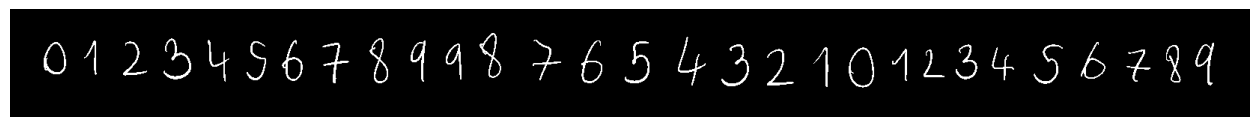

In [91]:
# načtení obrázku
img = cv.imread("TEST-final.png")


# zpracování obrázku
img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
img[img >= 127] = 255
img[img < 127] = 0
img = np.invert(img)

# nalezení kontur číslic
contours, hierarchy = cv.findContours(img, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

# seřazení kontur zleva doprava
sorted_contours = sorted(contours, key=lambda ctr: cv.boundingRect(ctr)[0])

# napočítání FD
FD_array = []
for contour in sorted_contours:
    FD = fourier_descriptors(contour, 30)
    FD_array.append(FD)


# predikce
knn_predicted = knn.predict(FD_array)

svm_predicted = svm.predict(FD_array)

rf_predicted = rf.predict(FD_array)

y_predicted = winners(knn_predicted, svm_predicted, rf_predicted)

print(y_predicted)

# vykreslení původního obrázku
plt.figure(figsize=(16,6))
plt.imshow(img, cmap="gray")
plt.axis("off")
plt.show()

## Výsledky

Program správně klasifikuje 97% číslic z testovacího datasetu (tvořen z celého datasetu v poměru 20:80).

V reálném testu se ukázalo, že špatně zaklasifikoval pouze jednu číslici: 6 klasifikoval jako 0.

